# The case when the two data sets are correlated
### C: the covariance matrix of the two data sets.

### If we choose the mapping matrix ${\bf A}_1 = {\bf I}, {\bf A}_2 = R{\bf I}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
from matplotlib.ticker import AutoMinorLocator
from numpy.linalg import inv

fontsize=22
matplotlib.rcParams.update({'font.size':fontsize})

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
N_d = 10  # number of data points

def generate_data_sets(N_d):
    '''
    Generate two Gaussian data sets.
    '''
    d1 = np.random.normal(loc = 1, scale = 0.2, size=N_d) # d1, d2 are Gaussian distributed
    d2 = np.random.normal(loc = 2, scale = 0.4, size=N_d) 

    n1 = np.random.rand(N_d)*0.2  # random fractional error
    n2 = np.random.rand(N_d)*0.4
    C11 = np.diag(n1**2)
    C22 = np.diag(n2**2)

    # here we consider the off-diagonal terms, assuming C12 is a zeros matrix,
    # put your covariance matrix C12, C21 here
    C12 = np.zeros((N_d, N_d))
    C21 = C12
    return d1, d2, n1, n2, C11, C12, C21, C22

d1, d2, n1, n2, C11, C12, C21, C22 = generate_data_sets(N_d)

In [3]:
np.save('example_data/d1.npy', d1)
np.save('example_data/d2.npy', d2)
np.save('example_data/C11.npy', C11)
np.save('example_data/C12.npy', C12)
np.save('example_data/C21.npy', C21)
np.save('example_data/C22.npy', C22)
# If we apply this d1, d2, C11, C22 as the inputs in the simplest case,
# the ratio result is identical.
# because C12=C21=0 matrix is a special case of correlated data case

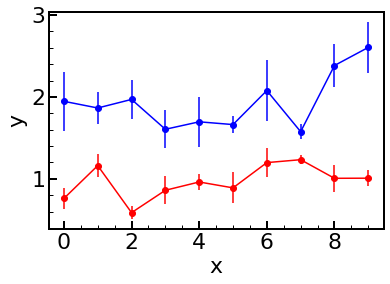

In [4]:
def plot_data_sets(N_d, d1, d2, n1, n2):
    plt.errorbar(np.arange(N_d), d1, n1, c = 'r', marker='o', label='d1')
    plt.errorbar(np.arange(N_d), d2, n2, c = 'b', marker='o', label='d2')
    plt.xlabel('x')
    plt.ylabel('y')
    ax = plt.gca()
    xminorLocator = AutoMinorLocator()
    yminorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(labelsize=fontsize)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='x',which='major',size=8,width=2)
    ax.tick_params(axis='y',which='major',size=8,width=2)
    ax.tick_params(axis='x',which='minor',size=4,width=1)
    ax.tick_params(axis='y',which='minor',size=4,width=1)
plot_data_sets(N_d, d1, d2, n1, n2)

In [5]:
def unbiased_R_estimator_corr(d1, d2, C11, C12, C21, C22): # correlated d1, d2
    deltaR=0.001 
    R = np.arange(1,3,deltaR) # try various R
    NR = len(R)
    
    def Matrix3(M1,M2,M3): # Multiplication of three matrices
        return np.dot(np.dot(M1,M2),M3)

    def block_matrix(M11, M12, M21, M22):
        M = np.block([[M11, M12],[M21, M22]])
        return M
    
    def block_matrix_inverse(C11, C12, C21, C22):
        B11 = inv(C11 - Matrix3(C12, inv(C22), C21))
        B12 = - Matrix3(B11, C12, inv(C22))
        B21 = - Matrix3(inv(C22), C21, B11)
        B22 = inv(C22) + Matrix3(-B21, C12, inv(C22))
        return B11, B12, B21, B22
    
    def prob_R(d1, d2, C11, C12, C21, C22, R):
        d_vec = np.array((d1, d2)) # data vector d in Eq.11
        n = d1.shape[0]
        a1 = np.identity(n) # the mapping matrix A1, A2 is indentity
        a2 = a1 * R         # Eq.19 in paper
        B11, B12, B21, B22 = block_matrix_inverse(C11, C12, C21, C22)
        q = Matrix3(a1.T, B11, a1) + Matrix3(a1.T, B12, a2) + Matrix3(a2.T, B21, a1) + Matrix3(a2.T, B22, a2) # Eq.14
        # print (d1.shape)
        d1 = d1.reshape(n,1)
        d2 = d2.reshape(n,1)
        t = Matrix3(a1.T, B11, d1) + Matrix3(a1.T, B12, d2) + Matrix3(a2.T, B21, d1) + Matrix3(a2.T, B22, d2) # Eq.15
        return 0.5 * Matrix3(t.T, inv(q), t), np.sqrt(np.linalg.det(q)) # two terms in Eq.17 (exp index term & det term)

    def pdf(d1,d2,C11,C12,C21,C22,R):
        Exp_index=[]; DetQ=[]
        for rr in range(NR):
            exp_index, detQ = prob_R(d1=d1,d2=d2,C11=C11,C12=C12,C21=C21,C22=C22,R=R[rr])
            Exp_index.append(exp_index)
            DetQ.append(detQ)
        Exp_index = np.array(Exp_index).reshape(NR)
        index_max = max(Exp_index)

        # To avoid numerical errors associated with too large/small exponential terms,
        # a safer way is to evaluate the r.h.s of Eq.10 as a function of R,
        # find the maximum, and then subtract this maximum before evaluating P(R).
        PROB = np.exp(Exp_index - index_max) * DetQ
        y = PROB/PROB.max() / R  # Jefferys 1/R prior
        area = deltaR * np.sum(y)
        y_norm = y / area   # PDF normalization
        max_index = np.argmax(y_norm)
        R_mean = R[max_index]  # find the bestfit R, which means PDF reaches the maximum
        return max_index, R_mean, y_norm

    def pdf_1sigma(max_index, R_mean, y_norm):
        # find the lower limit of R, which requires the integral area is 0.34 (1-sigma)
        f = np.ones(max_index)
        for x in range(0,max_index):
            f[x] = abs(0.34 / deltaR - np.sum(y_norm[x:max_index])) 
        x1 = np.argmin(f)  # the index of lower limit R

        # find the upper limit of R, which requires the integral area is 0.34 (1-sigma)
        v = np.ones(NR - max_index)
        for u in range(max_index,NR):
            v[u-max_index] = abs(0.34 / deltaR - np.sum(y_norm[max_index:u]))
        x2 = max_index + np.argmin(v) # the index of upper limit R

        delta_x1 = R[max_index] - R[x1]
        delta_x2 = R[x2] - R[max_index]
        return x1, x2, delta_x1, delta_x2
    
    def gaussian_func(mu,sigma):
        gau = 1./np.sqrt(2*np.pi) * np.exp(-(R-mu)**2 / 2./sigma**2)
        return gau
    
    max_index, R_mean, y_norm = pdf(d1,d2,C11, C12, C21, C22,R)
    x1, x2, delta_x1, delta_x2 = pdf_1sigma(max_index, R_mean, y_norm)
    
    delta_x = (delta_x1 + delta_x2) / 2
    gau = gaussian_func(R_mean, delta_x)
    sum_gau = np.sum(gau)*deltaR
    gau_norm = gau / sum_gau
    
    return R, R_mean, y_norm, x1, x2, max_index, delta_x1, delta_x2, gau_norm

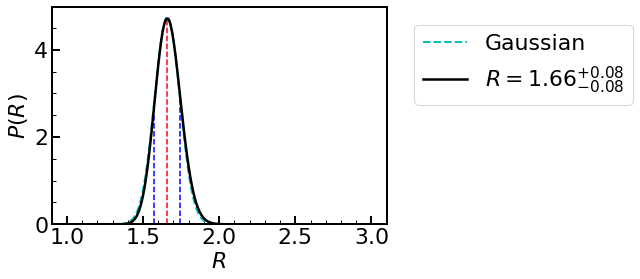

In [6]:
def plot_pdf():
    R, R_mean, y_norm, x1, x2, max_index, delta_x1, delta_x2, gau_norm = unbiased_R_estimator_corr(d1,d2,C11, C12, C21, C22)
    plt.plot(R,gau_norm,'c--',lw=2, label='Gaussian')
    
    plt.plot(R,y_norm,'k', lw=2.5, label='$R = %1.2f^{+%.2f}_{-%.2f}$'%(R_mean, delta_x2, delta_x1))
    plt.vlines(R_mean, 0, y_norm[max_index], color='r',ls='--')
    plt.vlines(R[x1], 0, y_norm[x1], color='b',ls='--')
    plt.vlines(R[x2], 0, y_norm[x2], color='b',ls='--')
    
    ax = plt.gca()
    xminorLocator = AutoMinorLocator()
    yminorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(labelsize=fontsize)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='x',which='major',size=8,width=2)
    ax.tick_params(axis='y',which='major',size=8,width=2)
    ax.tick_params(axis='x',which='minor',size=4,width=1)
    ax.tick_params(axis='y',which='minor',size=4,width=1)
    plt.xlabel('$R$')
    plt.ylabel('$P(R)$')
    plt.ylim(0)
    plt.legend(fontsize=fontsize, bbox_to_anchor=(1.05, 0.5), loc=3)
plot_pdf()